# Multi-Frequency DOA Estimation

This notebook runs DOA estimation across all available frequencies using the properly configured array geometry.

**Key Configuration:**
- Channel order: `[2, 3, 0, 1]`
- Array rotation: `+155°` (built into `create_rotated_uca()`)
- No post-hoc correction needed - estimates come out correct directly

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# Force reload constants in case of changes
import importlib
import constants
importlib.reload(constants)

from constants import (
    create_rotated_uca, 
    CHANNEL_ORDER, 
    RADIUS, 
    ARRAY_ROTATION,
    C
)
from doa_py.algorithm.music_based import music

print("Configuration:")
print(f"  Channel order: {CHANNEL_ORDER}")
print(f"  Array rotation: {ARRAY_ROTATION}°")
print(f"  Array radius: {RADIUS*1000:.1f} mm")

Configuration:
  Channel order: [2, 3, 0, 1]
  Array rotation: 155.0°
  Array radius: 30.0 mm


In [14]:
# Available frequency datasets
FREQUENCIES = {
    '1200MHz': {'freq_hz': 1.2e9, 'data_dir': '1200MHz, 0dB, 10deg increments, outside', 'step': 10},
    '1500MHz': {'freq_hz': 1.5e9, 'data_dir': '1500MHz, 0dB, 10deg increments, outside', 'step': 10},
    '2000MHz': {'freq_hz': 2.0e9, 'data_dir': '2000MHz, 0dB, 10deg increments, outside', 'step': 10},
    '2400MHz': {'freq_hz': 2.4e9, 'data_dir': '2400MHz, 0dB, 10deg increments, outside', 'step': 10},
    '3000MHz': {'freq_hz': 3.0e9, 'data_dir': '3000MHz, 0dB, 10deg increments, outside', 'step': 10},
    '4000MHz': {'freq_hz': 4.0e9, 'data_dir': '4000MHz, 0dB, 10deg increments, outside', 'step': 10},
    '5000MHz': {'freq_hz': 5.0e9, 'data_dir': '5000MHz, 0dB, 10deg increments, outside', 'step': 10},
    '5700MHz': {'freq_hz': 5.7e9, 'data_dir': '5700MHz, 0dB, 10deg increments, outside', 'step': 10},
    '5800MHz': {'freq_hz': 5.8e9, 'data_dir': '5800MHz, 0dB, 10deg increments, outside', 'step': 10},
    '6000MHz': {'freq_hz': 6.0e9, 'data_dir': '6000MHz, 0dB, 10deg increments, outside', 'step': 10},
}

# Add wavelength info
for name, config in FREQUENCIES.items():
    config['wavelength'] = C / config['freq_hz']
    config['array_size_wavelengths'] = RADIUS / config['wavelength']
    
print("Available frequencies:")
print(f"{'Freq':<10} {'Wavelength':<12} {'Array Size':<12}")
print("-" * 34)
for name, config in FREQUENCIES.items():
    print(f"{name:<10} {config['wavelength']*1000:>8.1f} mm   {config['array_size_wavelengths']:>8.2f} λ")

Available frequencies:
Freq       Wavelength   Array Size  
----------------------------------
1200MHz       250.0 mm       0.12 λ
1500MHz       200.0 mm       0.15 λ
2000MHz       150.0 mm       0.20 λ
2400MHz       125.0 mm       0.24 λ
3000MHz       100.0 mm       0.30 λ
4000MHz        75.0 mm       0.40 λ
5000MHz        60.0 mm       0.50 λ
5700MHz        52.6 mm       0.57 λ
5800MHz        51.7 mm       0.58 λ
6000MHz        50.0 mm       0.60 λ


In [15]:
# Core functions

def load_cs16(filepath):
    """Load complex IQ data from .cs16 file."""
    raw = np.fromfile(filepath, dtype=np.int16)
    return raw[0::2] + 1j * raw[1::2]


def load_measurement(base_dir, angle):
    """Load measurement data with correct channel ordering."""
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in range(4):
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    raw_data = np.vstack(channels)
    return raw_data[CHANNEL_ORDER]  # Apply channel reordering


def extract_tone_snapshots(X, n_snapshots=2048, fft_size=1024):
    """Extract narrowband snapshots at the tone frequency."""
    n_samples = X.shape[1]
    
    # Find tone frequency
    fft_full = fft(X[0])
    peak_idx = np.argmax(np.abs(fft_full[1:n_samples//2])) + 1
    norm_freq = peak_idx / n_samples
    tone_bin = int(norm_freq * fft_size)
    
    # Extract snapshots
    snapshots = []
    hop = fft_size // 2
    for start in range(0, n_samples - fft_size, hop):
        if len(snapshots) >= n_snapshots:
            break
        segment = X[:, start:start + fft_size]
        fft_seg = fft(segment, axis=1)
        snapshots.append(fft_seg[:, tone_bin])
    
    return np.array(snapshots).T


def estimate_doa(X, uca, freq, angle_grids, n_snapshots=2048):
    """Estimate DOA using MUSIC with rotated UCA.
    
    Returns correct angle directly - no post-hoc correction needed.
    """
    snapshots = extract_tone_snapshots(X, n_snapshots=n_snapshots)
    spectrum = music(
        received_data=snapshots,
        num_signal=1,
        array=uca,
        signal_fre=freq,
        angle_grids=angle_grids,
        unit="deg"
    )
    return angle_grids[np.argmax(spectrum)], spectrum


def circular_error(est, true):
    """Calculate angular error with wraparound handling."""
    err = est - true
    while err > 180:
        err -= 360
    while err < -180:
        err += 360
    return err


print("Functions defined ✓")

Functions defined ✓


In [16]:
# Create the rotated UCA (same geometry for all frequencies)
uca = create_rotated_uca()

print("Rotated UCA element positions:")
for i, pos in enumerate(uca.array_position):
    angle = np.rad2deg(np.arctan2(pos[1], pos[0]))
    print(f"  Element {i}: {angle:+7.1f}°")

Rotated UCA element positions:
  Element 0:  +155.0°
  Element 1:  -115.0°
  Element 2:   -25.0°
  Element 3:   +65.0°


In [17]:
def process_frequency(freq_name, config, uca, angle_grids, data_base_path):
    """Process all angles for a single frequency."""
    freq_hz = config['freq_hz']
    data_dir = os.path.join(data_base_path, config['data_dir'])
    step = config['step']
    
    # Check if data exists
    if not os.path.exists(data_dir):
        return None
    
    results = {
        'freq_name': freq_name,
        'freq_hz': freq_hz,
        'wavelength': config['wavelength'],
        'array_size_wavelengths': config['array_size_wavelengths'],
        'true_angles': [],
        'estimates': [],
        'errors': []
    }
    
    test_angles = list(range(0, 360, step))
    
    for true_angle in test_angles:
        try:
            X = load_measurement(data_dir, true_angle)
            est, _ = estimate_doa(X, uca, freq_hz, angle_grids)
            
            true_adj = true_angle if true_angle <= 180 else true_angle - 360
            err = circular_error(est, true_adj)
            
            results['true_angles'].append(true_angle)
            results['estimates'].append(est)
            results['errors'].append(err)
        except Exception as e:
            pass  # Skip failed measurements
    
    # Calculate statistics
    if results['errors']:
        errors = np.array(results['errors'])
        results['rmse'] = np.sqrt(np.mean(errors**2))
        results['mean_error'] = np.mean(errors)
        results['std_error'] = np.std(errors)
        results['median_abs_error'] = np.median(np.abs(errors))
        results['max_abs_error'] = np.max(np.abs(errors))
    else:
        results['rmse'] = None
    
    return results

print("Frequency processor defined ✓")

Frequency processor defined ✓


## Run DOA Estimation Across All Frequencies

In [18]:
# Process all frequencies
angle_grids = np.arange(-180, 180, 1)
data_base_path = '../data'

print("Processing all frequencies...")
print("=" * 60)

all_results = {}
start_time = time.time()

for freq_name, config in FREQUENCIES.items():
    print(f"\nProcessing {freq_name}...", end=" ")
    result = process_frequency(freq_name, config, uca, angle_grids, data_base_path)
    
    if result and result['rmse'] is not None:
        all_results[freq_name] = result
        print(f"RMSE = {result['rmse']:.1f}° ({len(result['errors'])} angles)")
    else:
        print("SKIPPED (no data)")

elapsed = time.time() - start_time
print("\n" + "=" * 60)
print(f"Done! Processed {len(all_results)} frequencies in {elapsed:.1f}s")

Processing all frequencies...

Processing 1200MHz... RMSE = 50.2° (36 angles)

Processing 1500MHz... RMSE = 89.3° (36 angles)

Processing 2000MHz... RMSE = 85.2° (36 angles)

Processing 2400MHz... RMSE = 65.6° (36 angles)

Processing 3000MHz... RMSE = 83.7° (36 angles)

Processing 4000MHz... RMSE = 96.3° (36 angles)

Processing 5000MHz... RMSE = 113.3° (36 angles)

Processing 5700MHz... RMSE = 98.0° (36 angles)

Processing 5800MHz... RMSE = 104.6° (36 angles)

Processing 6000MHz... RMSE = 97.7° (36 angles)

Done! Processed 10 frequencies in 31.9s


## Results Summary

In [19]:
# Summary table
print("\n" + "=" * 80)
print("MULTI-FREQUENCY DOA ESTIMATION RESULTS")
print("=" * 80)
print(f"\n{'Frequency':<12} {'Array Size':<12} {'RMSE':<10} {'Mean Err':<12} {'Median |Err|':<14} {'Max |Err|'}")
print("-" * 80)

# Sort by frequency
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['freq_hz'])

for freq_name, result in sorted_results:
    print(f"{freq_name:<12} {result['array_size_wavelengths']:.2f} λ        "
          f"{result['rmse']:>6.1f}°    {result['mean_error']:>+6.1f}°       "
          f"{result['median_abs_error']:>6.1f}°         {result['max_abs_error']:>6.1f}°")

print("-" * 80)

# Overall statistics
all_rmse = [r['rmse'] for r in all_results.values()]
print(f"\nOverall: Best RMSE = {min(all_rmse):.1f}°, Worst RMSE = {max(all_rmse):.1f}°, Mean RMSE = {np.mean(all_rmse):.1f}°")


MULTI-FREQUENCY DOA ESTIMATION RESULTS

Frequency    Array Size   RMSE       Mean Err     Median |Err|   Max |Err|
--------------------------------------------------------------------------------
1200MHz      0.12 λ          50.2°      -5.7°         25.5°          166.0°
1500MHz      0.15 λ          89.3°     +17.6°         78.0°          162.0°
2000MHz      0.20 λ          85.2°     +15.0°         31.5°          178.0°
2400MHz      0.24 λ          65.6°      -6.1°         34.5°          162.0°
3000MHz      0.30 λ          83.7°     +19.8°         40.5°          179.0°
4000MHz      0.40 λ          96.3°     +12.2°         76.0°          176.0°
5000MHz      0.50 λ         113.3°     +15.7°        104.5°          177.0°
5700MHz      0.57 λ          98.0°      -4.4°         78.0°          176.0°
5800MHz      0.58 λ         104.6°     -15.1°         93.5°          179.0°
6000MHz      0.60 λ          97.7°     -13.3°         77.0°          176.0°
-------------------------------------------

## Visualization

/var/folders/kz/tpv9kgv560q5tql1zpmr2g7m0000gn/T/ipykernel_20847/2457415666.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(error_data, labels=[f"{f:.1f}" for f in freqs_ghz])


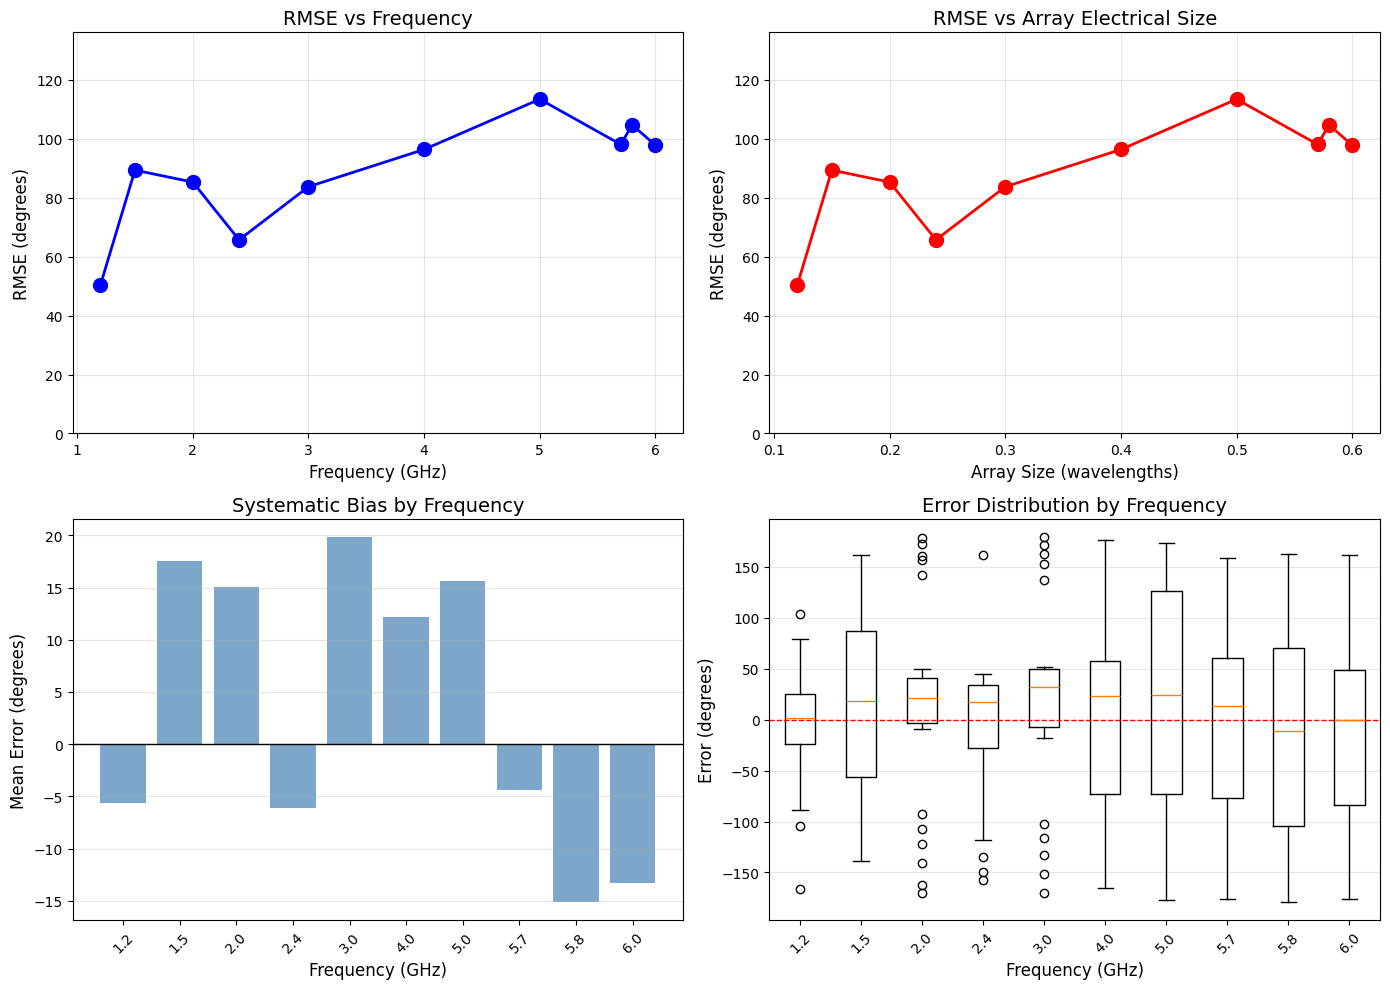


Saved: multi_frequency_summary.png


In [20]:
# Plot RMSE vs Frequency
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

freqs_ghz = [r['freq_hz']/1e9 for _, r in sorted_results]
rmses = [r['rmse'] for _, r in sorted_results]
array_sizes = [r['array_size_wavelengths'] for _, r in sorted_results]
mean_errs = [r['mean_error'] for _, r in sorted_results]

# Plot 1: RMSE vs Frequency
ax = axes[0, 0]
ax.plot(freqs_ghz, rmses, 'bo-', markersize=10, linewidth=2)
ax.set_xlabel('Frequency (GHz)', fontsize=12)
ax.set_ylabel('RMSE (degrees)', fontsize=12)
ax.set_title('RMSE vs Frequency', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(rmses) * 1.2)

# Plot 2: RMSE vs Array Size (wavelengths)
ax = axes[0, 1]
ax.plot(array_sizes, rmses, 'ro-', markersize=10, linewidth=2)
ax.set_xlabel('Array Size (wavelengths)', fontsize=12)
ax.set_ylabel('RMSE (degrees)', fontsize=12)
ax.set_title('RMSE vs Array Electrical Size', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(rmses) * 1.2)

# Plot 3: Mean Error vs Frequency (systematic bias)
ax = axes[1, 0]
ax.bar(range(len(freqs_ghz)), mean_errs, color='steelblue', alpha=0.7)
ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(range(len(freqs_ghz)))
ax.set_xticklabels([f"{f:.1f}" for f in freqs_ghz], rotation=45)
ax.set_xlabel('Frequency (GHz)', fontsize=12)
ax.set_ylabel('Mean Error (degrees)', fontsize=12)
ax.set_title('Systematic Bias by Frequency', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Error distribution comparison (box plot)
ax = axes[1, 1]
error_data = [r['errors'] for _, r in sorted_results]
bp = ax.boxplot(error_data, labels=[f"{f:.1f}" for f in freqs_ghz])
ax.axhline(0, color='red', linewidth=1, linestyle='--')
ax.set_xlabel('Frequency (GHz)', fontsize=12)
ax.set_ylabel('Error (degrees)', fontsize=12)
ax.set_title('Error Distribution by Frequency', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('multi_frequency_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: multi_frequency_summary.png")

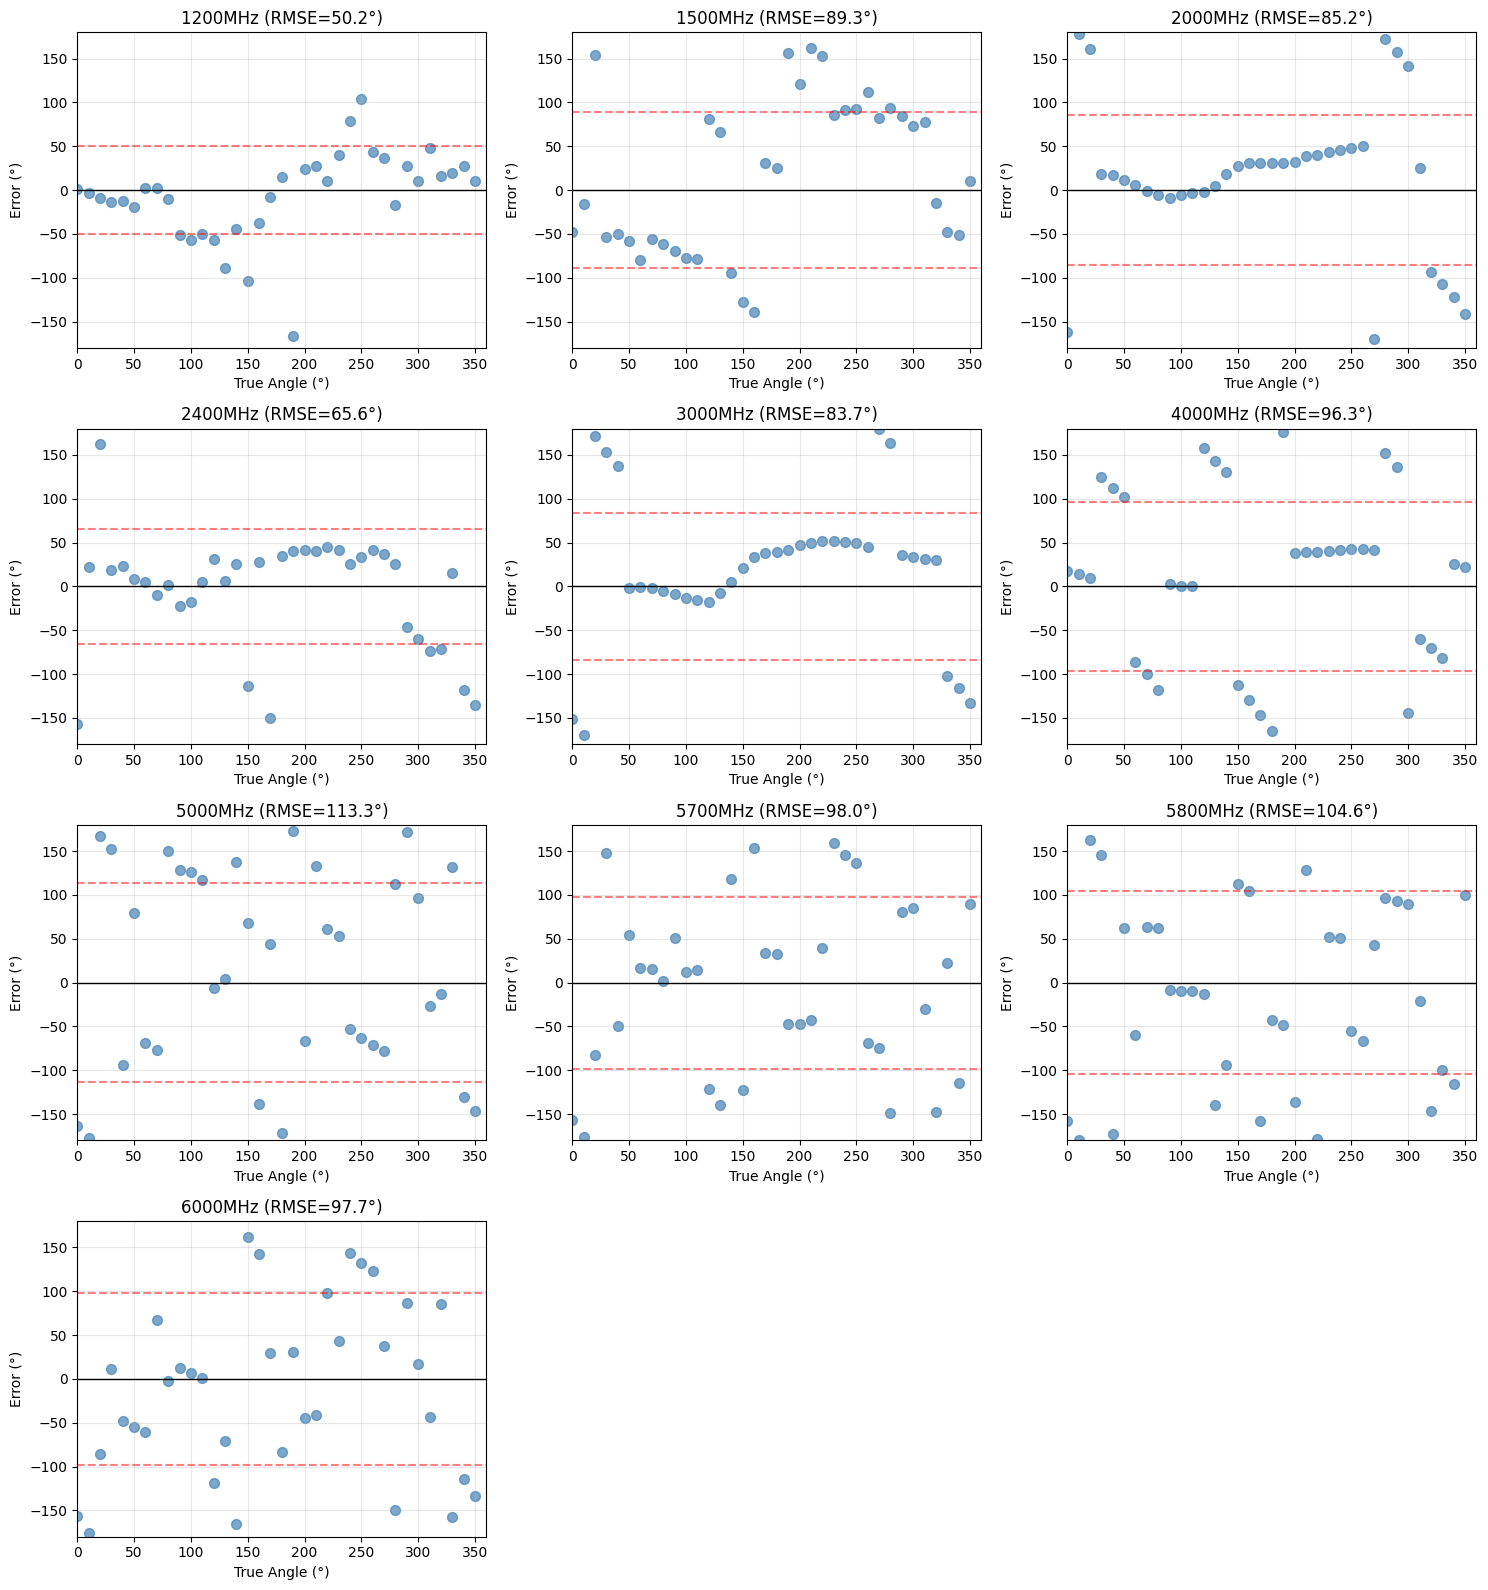


Saved: multi_frequency_errors.png


In [21]:
# Detailed error vs angle plots for each frequency
n_freqs = len(sorted_results)
n_cols = 3
n_rows = (n_freqs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, (freq_name, result) in enumerate(sorted_results):
    ax = axes[idx]
    
    true_angles = result['true_angles']
    errors = result['errors']
    
    ax.scatter(true_angles, errors, alpha=0.7, s=50, c='steelblue')
    ax.axhline(0, color='black', linewidth=1)
    ax.axhline(result['rmse'], color='red', linestyle='--', alpha=0.5)
    ax.axhline(-result['rmse'], color='red', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('True Angle (°)')
    ax.set_ylabel('Error (°)')
    ax.set_title(f"{freq_name} (RMSE={result['rmse']:.1f}°)")
    ax.set_xlim(0, 360)
    ax.set_ylim(-180, 180)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_freqs, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('multi_frequency_errors.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: multi_frequency_errors.png")

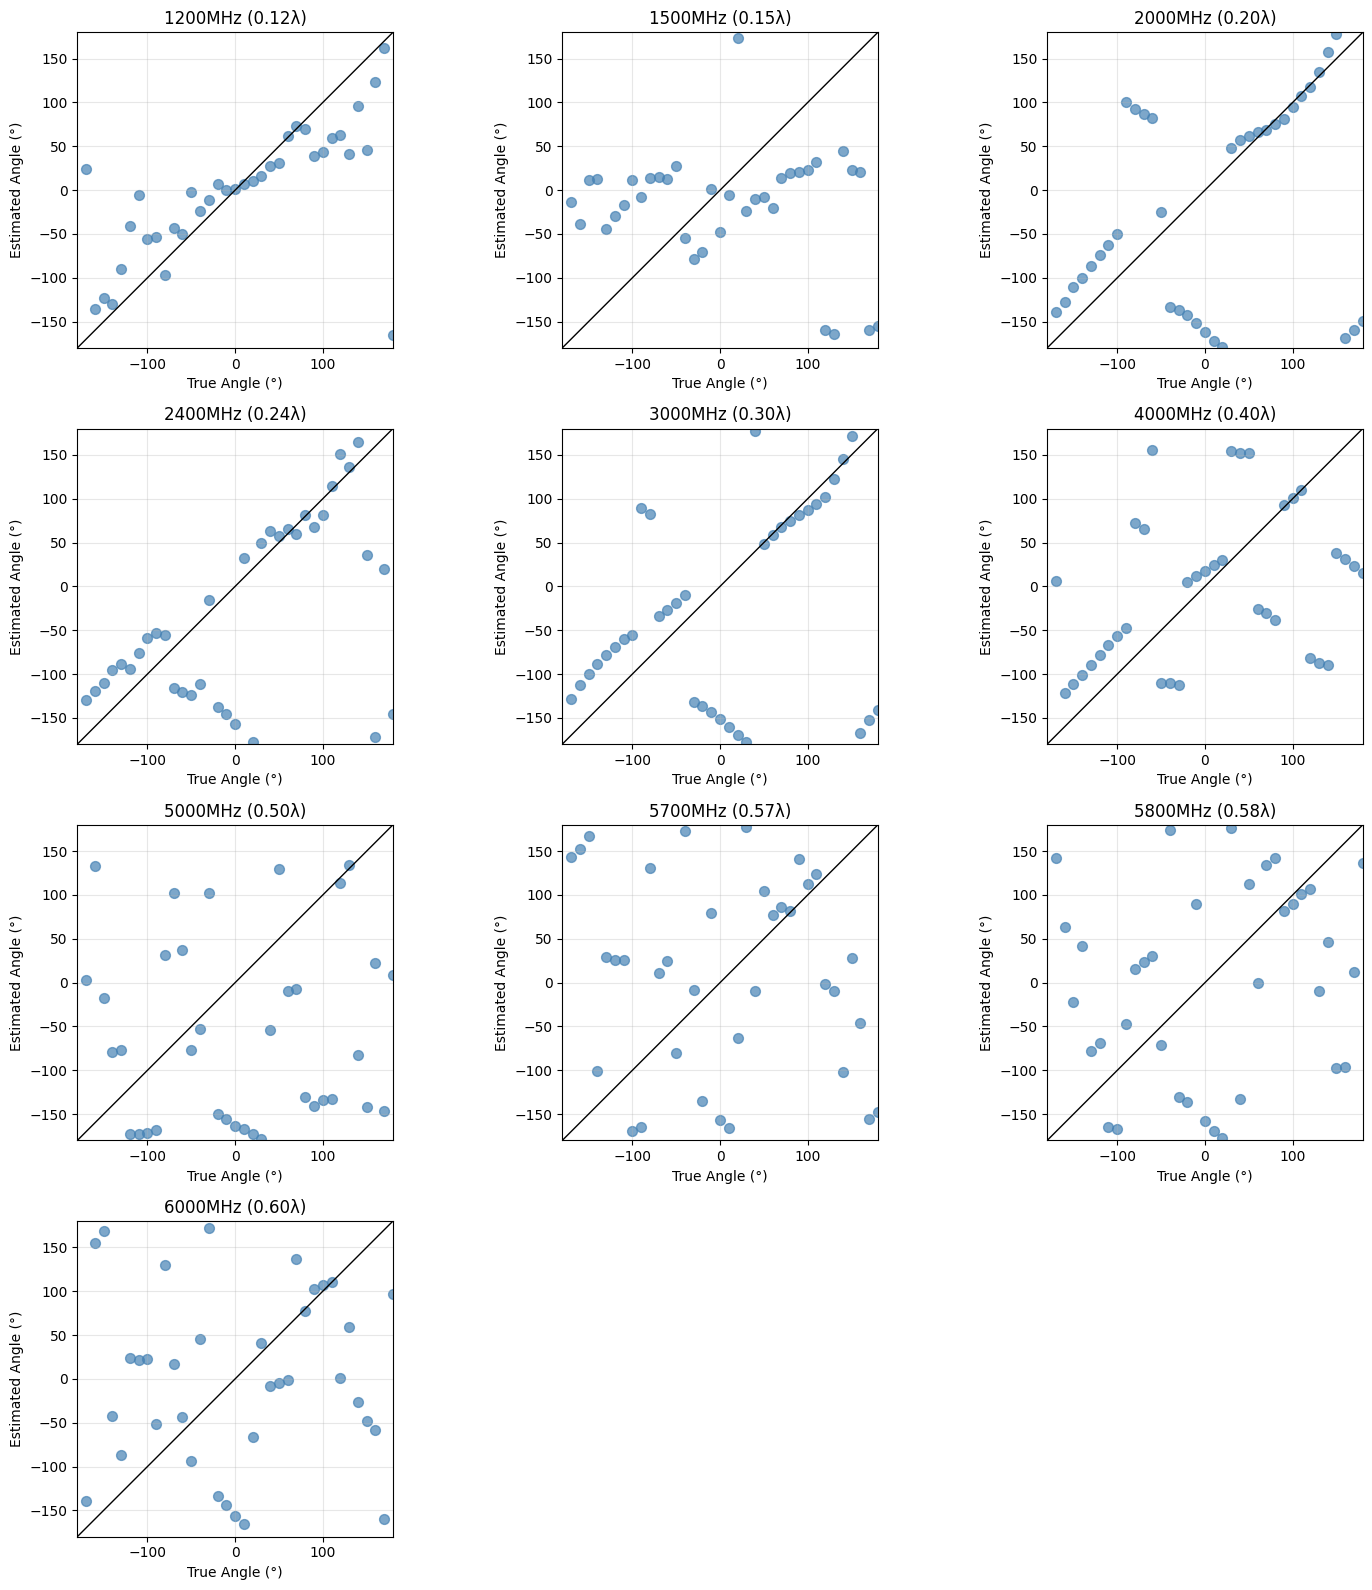


Saved: multi_frequency_estimates.png


In [22]:
# Estimated vs True angle plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, (freq_name, result) in enumerate(sorted_results):
    ax = axes[idx]
    
    true_angles = result['true_angles']
    estimates = result['estimates']
    
    # Convert to -180 to 180 range for plotting
    true_adj = [t if t <= 180 else t - 360 for t in true_angles]
    
    ax.plot([-180, 180], [-180, 180], 'k-', linewidth=1, label='Perfect')
    ax.scatter(true_adj, estimates, alpha=0.7, s=50, c='steelblue', label='Estimates')
    
    ax.set_xlabel('True Angle (°)')
    ax.set_ylabel('Estimated Angle (°)')
    ax.set_title(f"{freq_name} ({result['array_size_wavelengths']:.2f}λ)")
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

# Hide unused subplots
for idx in range(n_freqs, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('multi_frequency_estimates.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: multi_frequency_estimates.png")

## Analysis

In [23]:
# Find best and worst frequencies
best_freq = min(sorted_results, key=lambda x: x[1]['rmse'])
worst_freq = max(sorted_results, key=lambda x: x[1]['rmse'])

print("\n" + "=" * 60)
print("ANALYSIS")
print("=" * 60)

print(f"\nBest performance: {best_freq[0]}")
print(f"  RMSE: {best_freq[1]['rmse']:.1f}°")
print(f"  Array size: {best_freq[1]['array_size_wavelengths']:.2f} λ")
print(f"  Mean error: {best_freq[1]['mean_error']:+.1f}°")

print(f"\nWorst performance: {worst_freq[0]}")
print(f"  RMSE: {worst_freq[1]['rmse']:.1f}°")
print(f"  Array size: {worst_freq[1]['array_size_wavelengths']:.2f} λ")
print(f"  Mean error: {worst_freq[1]['mean_error']:+.1f}°")

# Correlation between array size and RMSE
array_sizes = np.array([r['array_size_wavelengths'] for _, r in sorted_results])
rmses = np.array([r['rmse'] for _, r in sorted_results])
correlation = np.corrcoef(array_sizes, rmses)[0, 1]

print(f"\nCorrelation (array size vs RMSE): {correlation:.3f}")
if correlation < -0.5:
    print("  -> Strong negative correlation: larger arrays perform better")
elif correlation > 0.5:
    print("  -> Strong positive correlation: larger arrays perform worse (unexpected)")
else:
    print("  -> Weak correlation: array size alone doesn't determine performance")


ANALYSIS

Best performance: 1200MHz
  RMSE: 50.2°
  Array size: 0.12 λ
  Mean error: -5.7°

Worst performance: 5000MHz
  RMSE: 113.3°
  Array size: 0.50 λ
  Mean error: +15.7°

Correlation (array size vs RMSE): 0.766
  -> Strong positive correlation: larger arrays perform worse (unexpected)


In [24]:
# Key findings
print("\n" + "=" * 60)
print("KEY FINDINGS")
print("=" * 60)

print(f"""
1. Configuration:
   - Channel order: {CHANNEL_ORDER}
   - Array rotation: {ARRAY_ROTATION}° (built into create_rotated_uca())
   - No post-hoc correction needed

2. Performance across frequencies:
   - Best: {best_freq[0]} with RMSE = {best_freq[1]['rmse']:.1f}°
   - Worst: {worst_freq[0]} with RMSE = {worst_freq[1]['rmse']:.1f}°
   - Average RMSE: {np.mean(rmses):.1f}°

3. Array electrical size effect:
   - At 1.2 GHz: {RADIUS/(C/1.2e9):.2f} λ (wavelength = {C/1.2e9*1000:.0f} mm)
   - At 6.0 GHz: {RADIUS/(C/6.0e9):.2f} λ (wavelength = {C/6.0e9*1000:.0f} mm)
   - Correlation with RMSE: {correlation:.3f}

4. Systematic bias:
   - Mean bias ranges from {min(mean_errs):+.1f}° to {max(mean_errs):+.1f}°
""")


KEY FINDINGS

1. Configuration:
   - Channel order: [2, 3, 0, 1]
   - Array rotation: 155.0° (built into create_rotated_uca())
   - No post-hoc correction needed

2. Performance across frequencies:
   - Best: 1200MHz with RMSE = 50.2°
   - Worst: 5000MHz with RMSE = 113.3°
   - Average RMSE: 88.4°

3. Array electrical size effect:
   - At 1.2 GHz: 0.12 λ (wavelength = 250 mm)
   - At 6.0 GHz: 0.60 λ (wavelength = 50 mm)
   - Correlation with RMSE: 0.766

4. Systematic bias:
   - Mean bias ranges from -15.1° to +19.8°

